# 1. Install important dependencies

In [ ]:
# # Install necessary packages
!pip install transformers nltk datasets numpy seaborn pandas scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


# 2. Import Dependencies

In [ ]:
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

# To import the Transformer Models
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# to convert to Dataset datatype - the transformers library does not work well with pandas
from datasets import Dataset

### 2.1 Load the dataset

In [ ]:
import pandas as pd
import zipfile

# Open the zip file
with zipfile.ZipFile("/content/archive.zip") as z:
    # Get a list of files in the zip archive
    file_list = z.namelist()

    # Choose the file you want to read (e.g., 'train.csv')
    file_to_read = 'train.csv'  # or 'test.csv', depending on your need

    # Check if the chosen file exists in the archive
    if file_to_read in file_list:
        # Read the chosen file into a DataFrame
        with z.open(file_to_read) as f:
            df = pd.read_csv(f)

        # Display the first few rows of the DataFrame
        print(df.head())
    else:
        print(f"File '{file_to_read}' not found in the ZIP archive.")

   Class Index                                              Title  \
0            3  Wall St. Bears Claw Back Into the Black (Reuters)   
1            3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2            3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3            3  Iraq Halts Oil Exports from Main Southern Pipe...   
4            3  Oil prices soar to all-time record, posing new...   

                                         Description  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...  
3  Reuters - Authorities have halted oil export\f...  
4  AFP - Tearaway world oil prices, toppling reco...  


In [ ]:
df = df.rename(columns={'Class Index':'label'})
df.head()

,label,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


### 2.2 Data statistics

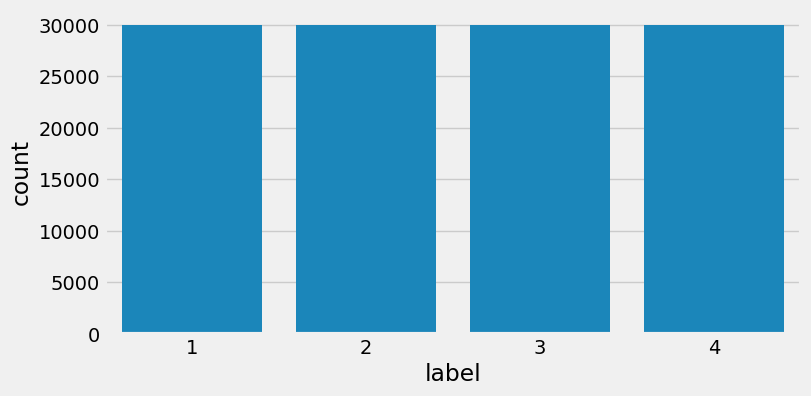

In [ ]:
# checking for unbalanced dataset
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8,4))
sns.countplot(x=df['label'])
plt.show()

### 2.3 Check for null values

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   label        120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


# 3. Data Preprocessing

In [ ]:
# concatinating the 'title' and 'description' column
df['text']=(df['Title']+df['Description'])
df.drop(columns=['Title','Description'],axis=1,inplace=True)
df.head()

,label,text
0,3,Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new..."


In [ ]:
# Text before preprocessing - contains symbols like ()\-,.' which is not useful
df['text'][1]

'Carlyle Looks Toward Commercial Aerospace (Reuters)Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.'

### 3.1 Remove Punctuations

In [ ]:
import re   # regular expression can be used to remove any punctuation or unnecessary symbols

In [ ]:
def remove_punctuations(text):
     text=re.sub(r'[\\-]',' ',text)
     text=re.sub(r'[,.?;:\'(){}!|0-9]','',text)
     return text

# the apply method applies a function along an axis of dataframe
df['text']=df['text'].apply(remove_punctuations)
df.head()

,label,text
0,3,Wall St Bears Claw Back Into the Black Reuters...
1,3,Carlyle Looks Toward Commercial Aerospace Reut...
2,3,Oil and Economy Cloud Stocks Outlook ReutersRe...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,Oil prices soar to all time record posing new ...


In [ ]:
import nltk

# downloading corpus only would work
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all


       | 
       | Downloading package abc to /root/nltk_data...
       |   Package abc is already up-to-date!
       | Downloading package alpino to /root/nltk_data...
       |   Package alpino is already up-to-date!
       | Downloading package averaged_perceptron_tagger to
       |     /root/nltk_data...
       |   Package averaged_perceptron_tagger is already up-to-date!
       | Downloading package averaged_perceptron_tagger_eng to
       |     /root/nltk_data...
       |   Package averaged_perceptron_tagger_eng is already up-to-
       |       date!
       | Downloading package averaged_perceptron_tagger_ru to
       |     /root/nltk_data...
       |   Package averaged_perceptron_tagger_ru is already up-to-
       |       date!
       | Downloading package averaged_perceptron_tagger_rus to
       |     /root/nltk_data...
       |   Package averaged_perceptron_tagger_rus is already up-to-
       |       date!
       | Downloading package basque_grammars to /root/nltk_data...
     


---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

### 3.2 Remove StopWords

In [ ]:
from nltk.corpus import stopwords

# english stopwords
stopw=stopwords.words('english')
stopw[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [ ]:
def remove_stopwords(text):
    clean_text=[]
    for word in text.split(' '):
        if word not in stopw:
            clean_text.append(word)
    return ' '.join(clean_text)

# remove stopwords
df['text']=df['text'].apply(remove_stopwords)

# the class label in dataset contains labels as 1,2,3,4 but the model needs 0,1,2,3, so we subtract 1 from all
df['label']=df['label'].apply(lambda x:x-1)
df.head()

,label,text
0,2,Wall St Bears Claw Back Into Black ReutersReut...
1,2,Carlyle Looks Toward Commercial Aerospace Reut...
2,2,Oil Economy Cloud Stocks Outlook ReutersReuter...
3,2,Iraq Halts Oil Exports Main Southern Pipeline ...
4,2,Oil prices soar time record posing new menace ...


In [ ]:
df['text'][1]   # this is the final preprocessed text

'Carlyle Looks Toward Commercial Aerospace ReutersReuters   Private investment firm Carlyle Group reputation making well timed occasionally controversial plays defense industry quietly placed bets another part market'

### 3.3 Split the data into training and testing sets

In [ ]:
from sklearn.model_selection import train_test_split

# since training on the full dataset(120,000 samples) would be take so long, the train size is only taken to be 30%
train_df,test_df=train_test_split(df[['text','label']],train_size=.3,shuffle=True)
test_df=test_df[:10000]

In [ ]:
train_df.shape,test_df.shape    # training set has 36000 samples and testing set has 10000 samples

((36000, 2), (10000, 2))

### 3.4 Load a pre-built tokenizer and convert to tokens

In [ ]:
# load tokenizer from bert base uncased model available from huggingface.co
model_name='bert-base-uncased'
tokenizer=AutoTokenizer.from_pretrained(model_name)

In [ ]:
def preprocess_function(examples):
    """
    Tokenizes the given text

    input -> dataset (columns = text, label)
    output -> tokenized dataset (columns = text, label, input, attention)
    """
    return tokenizer(examples["text"], truncation=True)

def pipeline(dataframe):
    """
    Prepares the dataframe so that it can be given to the transformer model

    input -> pandas dataframe
    output -> tokenized dataset (columns = text, label, input, attention)
    """
    # This step isn't mentioned anywhere but is vital as Transformers library only seems to work with this Dataset data type
    dataset = Dataset.from_pandas(dataframe, preserve_index=False)
    tokenized_ds = dataset.map(preprocess_function, batched=True)
    tokenized_ds = tokenized_ds.remove_columns('text')
    return tokenized_ds

In [ ]:
# create pipeline for training data and testing data
tokenized_train = pipeline(train_df)
tokenized_test = pipeline(test_df)

Map:   0%|          | 0/36000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

# 4. Load a pre-trained model

### 4.1 Adjust Model training arguments

In [ ]:
# load bert-based-uncased model for fine tuning
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)

# adjust the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    save_strategy = 'epoch',
    optim='adamw_torch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# create the trainer from Trainer class in transformer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

### 4.2 Train the model

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import get_scheduler
from tqdm import tqdm
import matplotlib.pyplot as plt

# Create DataLoaders
train_dataloader = DataLoader(tokenized_train, batch_size=16, shuffle=True, collate_fn=data_collator)
eval_dataloader = DataLoader(tokenized_test, batch_size=16, collate_fn=data_collator)

# Define optimizer and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
num_training_steps = len(train_dataloader) * 3  # 3 epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
losses = []
global_steps = 0
model.train()

for epoch in range(3):  # 3 epochs
    print(f"Epoch {epoch + 1}/{3}")
    epoch_loss = 0
    progress_bar = tqdm(train_dataloader, desc="Training")
    for batch in progress_bar:
        batch = {key: val.to(device) for key, val in batch.items()}  # Move batch to device
        outputs = model(**batch)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        epoch_loss += loss.item()
        global_steps += 1
        losses.append((global_steps, loss.item()))
        progress_bar.set_postfix({"loss": loss.item()})

    print(f"Epoch Loss: {epoch_loss / len(train_dataloader)}")

# Save the model
model.save_pretrained("./results")
tokenizer.save_pretrained("./results")


Epoch 1/3


Training: 100%|██████████| 2250/2250 [07:54<00:00,  4.74it/s, loss=0.192]


Epoch Loss: 0.22095062617957592
Epoch 2/3


Training: 100%|██████████| 2250/2250 [07:51<00:00,  4.78it/s, loss=0.0583]


Epoch Loss: 0.13106624442173376
Epoch 3/3


Training: 100%|██████████| 2250/2250 [07:53<00:00,  4.75it/s, loss=0.0134]


Epoch Loss: 0.07260275875864965


('./results/tokenizer_config.json',
 './results/special_tokens_map.json',
 './results/vocab.txt',
 './results/added_tokens.json',
 './results/tokenizer.json')

###4.3 Evaluate the model

In [ ]:
from sklearn.metrics import accuracy_score

model.eval()
predictions, labels = [], []
progress_bar = tqdm(eval_dataloader, desc="Evaluating")

with torch.no_grad():
    for batch in progress_bar:
        batch = {key: val.to(device) for key, val in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=-1).cpu().numpy())
        labels.extend(batch["labels"].cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(labels, predictions)
print(f"Validation Accuracy: {accuracy:.4f}")


Evaluating: 100%|██████████| 625/625 [00:46<00:00, 13.51it/s]

Validation Accuracy: 0.9272


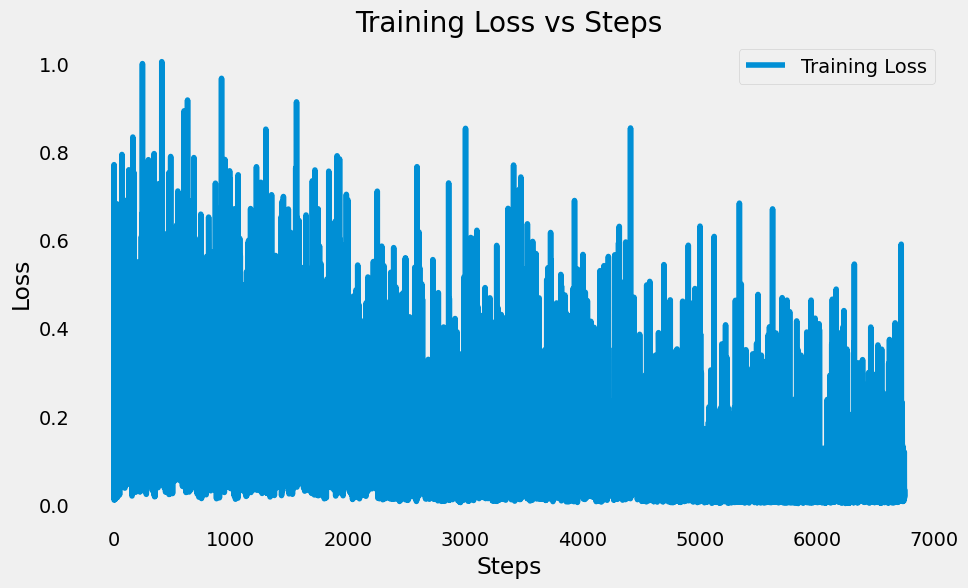

In [ ]:
# Extract steps and loss values
steps, step_losses = zip(*losses)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(steps, step_losses, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss vs Steps")
plt.legend()
plt.grid()
plt.show()


In [ ]:
from torch.utils.data import DataLoader

# Tokenize the test dataset
tokenized_test = test_df['text'].apply(lambda x: tokenizer(x, padding="max_length", truncation=True, return_tensors="pt"))
test_dataset = [{"input_ids": t["input_ids"].squeeze(),
                 "attention_mask": t["attention_mask"].squeeze()} for t in tokenized_test]
test_dataloader = DataLoader(test_dataset, batch_size=16)


In [ ]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

predictions = []
true_labels = test_df['label'].tolist()

# Predict
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=-1).cpu().numpy())


              precision    recall  f1-score   support

       World       0.93      0.93      0.93      2488
       Sport       0.98      0.98      0.98      2514
    Business       0.89      0.90      0.89      2488
    Sci/Tech       0.91      0.90      0.90      2510

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



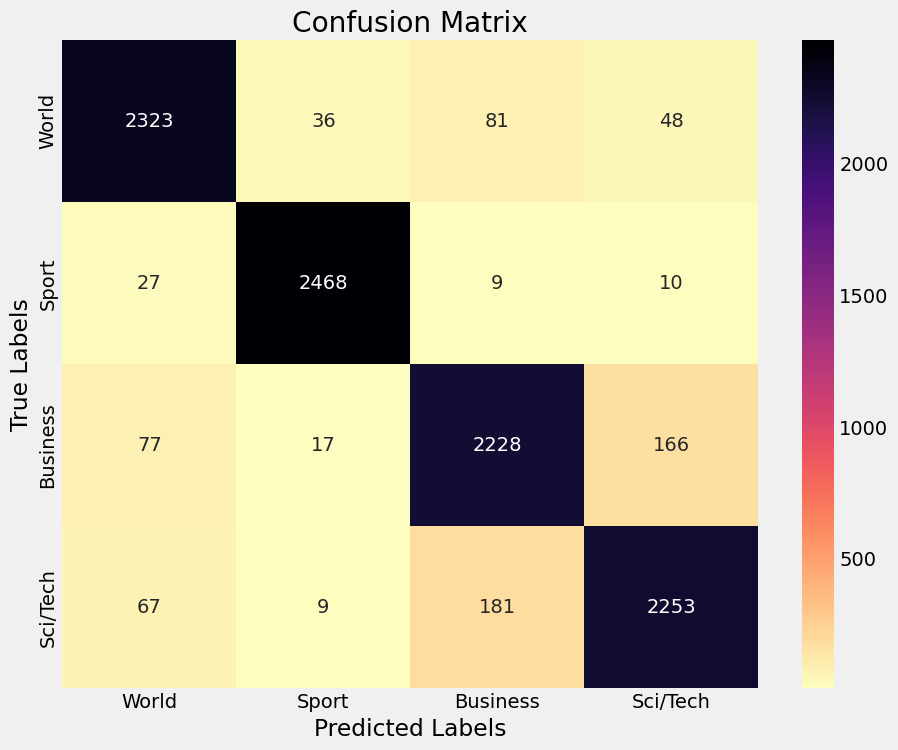

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Classification report
print(classification_report(true_labels, predictions, target_names=['World', 'Sport', 'Business', 'Sci/Tech']))

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    xticklabels=['World', 'Sport', 'Business', 'Sci/Tech'],
    yticklabels=['World', 'Sport', 'Business', 'Sci/Tech'],
    cmap=plt.cm.magma_r
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


### 4.4 Test model on random predictions

In [ ]:
import random

In [ ]:
# num=random.randint(0,len(test_df)-101)
# tokenized_test = pipeline(test_df[num:num+100]).remove_columns('label')

num = random.randint(0, len(test_df) - 101)
random_test_df = test_df.iloc[num:num + 100]

In [ ]:
# Perform manual predictions
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

predictions = []
true_labels = test_df['label'][num:num + 100].tolist()

# Tokenize and create DataLoader for the subset
tokenized_subset = random_test_df['text'].apply(lambda x: tokenizer(x, padding="max_length", truncation=True, return_tensors="pt"))
test_subset = [{"input_ids": t["input_ids"].squeeze(),
                "attention_mask": t["attention_mask"].squeeze()} for t in tokenized_subset]
test_dataloader = DataLoader(test_subset, batch_size=16)

# Predict
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=-1).cpu().numpy())

# Evaluate the performance
print("Accuracy on random 100 samples from the test dataset:")
print(classification_report(true_labels, predictions, target_names=['World', 'Sport', 'Business', 'Sci/Tech']))


Accuracy on random 100 samples from the test dataset:
              precision    recall  f1-score   support

       World       0.86      0.90      0.88        21
       Sport       0.96      1.00      0.98        23
    Business       0.91      0.91      0.91        32
    Sci/Tech       0.95      0.88      0.91        24

    accuracy                           0.92       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.92      0.92      0.92       100



### 4.5 Manually compare predictions on sample test data

In [ ]:
class_labels=['World','Sports','Business','Sci/Tech']

In [ ]:
import random
from torch.utils.data import DataLoader
import torch

# Randomly select a subset of 10 samples from the test dataset
num = random.randint(0, len(test_df) - 10)
random_test_df = test_df.iloc[num:num + 10]

# Tokenize the subset
tokenized_subset = random_test_df['text'].apply(lambda x: tokenizer(x, padding="max_length", truncation=True, return_tensors="pt"))
test_subset = [{"input_ids": t["input_ids"].squeeze(),
                "attention_mask": t["attention_mask"].squeeze()} for t in tokenized_subset]
test_dataloader = DataLoader(test_subset, batch_size=1)  # Batch size 1 for individual predictions

# Perform manual predictions
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

predictions = []
true_labels = random_test_df['label'].tolist()

# Predict
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=-1).cpu().numpy())

# Map class labels
print('Prediction\tActual\n----------------------')
for i in range(len(predictions)):
    print(f"{class_labels[predictions[i]]} ---> {class_labels[true_labels[i]]}")


Prediction	Actual
----------------------
World ---> World
Business ---> Business
World ---> World
Sci/Tech ---> Sci/Tech
World ---> World
World ---> World
Sci/Tech ---> Sci/Tech
World ---> Sports
Business ---> Business
Sci/Tech ---> Sci/Tech


# 5. Save Model

In [ ]:
# save_model method saves the model along with its metadata in the specified path
trainer.save_model('models')

# 6. Load Model

In [ ]:
# for loading model, we just need to specify the path of the folder for saved model
model = AutoModelForSequenceClassification.from_pretrained('models')
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

<ipython-input-56-c979bc15e312>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
